### Imports

In [71]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import scipy.signal as sg
import matplotlib.pyplot as plt
from neuropy import plotting
import subjects

### Ripples around start and stop of OFF periods

In [ ]:
from neuropy.utils.ccg import correlograms

sessions = subjects.sd.mua_sess

ccg_df = []
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    period = [post[0] + 4 * 3600, post[0] + 5 * 3600]
    off_epochs = sess.off_epochs.duration_slice(max_dur=2).time_slice(*period)
    off_durations = off_epochs.durations
    off_starts = off_epochs.starts
    off_stops = off_epochs.stops

    # rpl_starts = sess.ripple.time_slice(*period).starts
    rpl_starts = sess.ripple.time_slice(*period).to_dataframe().peak_time

    times = np.concatenate([rpl_starts, off_starts, off_stops])
    ids = np.concatenate(
        [
            np.ones_like(rpl_starts),
            2 * np.ones_like(off_starts),
            3 * np.ones_like(off_stops),
        ]
    )
    sort_ind = np.argsort(times)

    ccg = correlograms(
        times[sort_ind],
        ids[sort_ind].astype("int"),
        sample_rate=1250,
        bin_size=0.001,
        window_size=0.5,
    )

    df1 = pd.DataFrame(
        {
            "ccg": ccg[1, 0, :],
            "time": np.linspace(-0.25, 0.25, 501) - 0.1,
            "grp": "from_start",
        }
    )
    df2 = pd.DataFrame(
        {
            "ccg": ccg[2, 0, :],
            "time": np.linspace(-0.25, 0.25, 501) + 0.1,
            "grp": "from_stop",
        }
    )

    ccg_df.append(df1)
    ccg_df.append(df2)


ccg_df = pd.concat(ccg_df, ignore_index=True)


In [ ]:

fig = plotting.Fig(grid=(7,6),constrained_layout=False)

ax = plt.subplot(fig.gs[0])
sns.lineplot(data=ccg_df,x='time',y='ccg',ax=ax,ci='sd',palette=['#f94848']*2,hue='grp')
# ax.set_xlim([-0.03,0.03])
ax.legend([],frameon=False)
ax.tick_params("x", labelrotation=30)
# ax.set_ylim([0,48])
ax.axvline(-0.1,ls='--',color='k')
ax.axvline(0.1,ls='--',color='k')
ax.set_xticks([-0.25,-0.1,0.1,0.25],[-0.25,'start','stop',0.25])
ax.set_title('Ripples around off periods')
ax.set_xlabel('Relative to Off periods (ms)')
ax.set_ylabel('Counts')

# fig.savefig(subjects.figpath_sd/'ripples_around_off')

### Silence periods following ripple changes during SD using ISI
- Collect all spikes right before and after ripples and assess there interspike interval

In [73]:
sessions = subjects.sd.mua_sess


def get_isi(neurons, rpl_epochs):
    rpl_stops = rpl_epochs.stops
    starts = rpl_stops[:-1]
    stops = rpl_epochs.starts[1:] 
    sep = stops-starts
    sep[sep>0.2] = sep[sep>0.2]+0.2
    new_epochs = sess.ripple.from_array(starts+0.001, starts+sep)
    # spktrn = neurons.get_all_spikes()

    # new_spktrn = []
    # for e in range(3):
    #     e_epochs = new_epochs[e::3]

        # bin_loc = np.digitize(spktrn, bins)
        # new_spktrn.append(spktrn[bin_loc % 2 == 1])

    isi = neurons.get_neurons_in_epochs(new_epochs).get_isi()
    t = np.linspace(0,0.2,isi.shape[1])

    # new_spktrn = np.sort(np.concatenate(new_spktrn))
    # isi = np.diff(new_spktrn)
    # isi_bins = np.arange(0, 0.1, 0.001)
    # isi_hist = np.histogram(isi, isi_bins)[0]

    # return isi_hist, isi_bins[:-1]
    return isi.mean(axis=0),t


isi_df = []
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    period1 = [post[0], post[0] + 1 * 3600]
    period2 = [post[0] + 4 * 3600, post[0] + 5 * 3600]

    rpls = sess.ripple
    neurons = sess.neurons_stable.get_neuron_type(['pyr','inter'])
    isi1,t = get_isi(neurons.time_slice(*period1), rpls.time_slice(*period1))
    isi2, _ = get_isi(neurons.time_slice(*period2), rpls.time_slice(*period2))

    isi_df.append(pd.DataFrame({"t": t, "isi1": isi1, "isi2": isi2}))

isi_df = pd.concat(isi_df, ignore_index=True)


ValueError: bins must be monotonically increasing or decreasing

<Axes: xlabel='t', ylabel='isi1'>

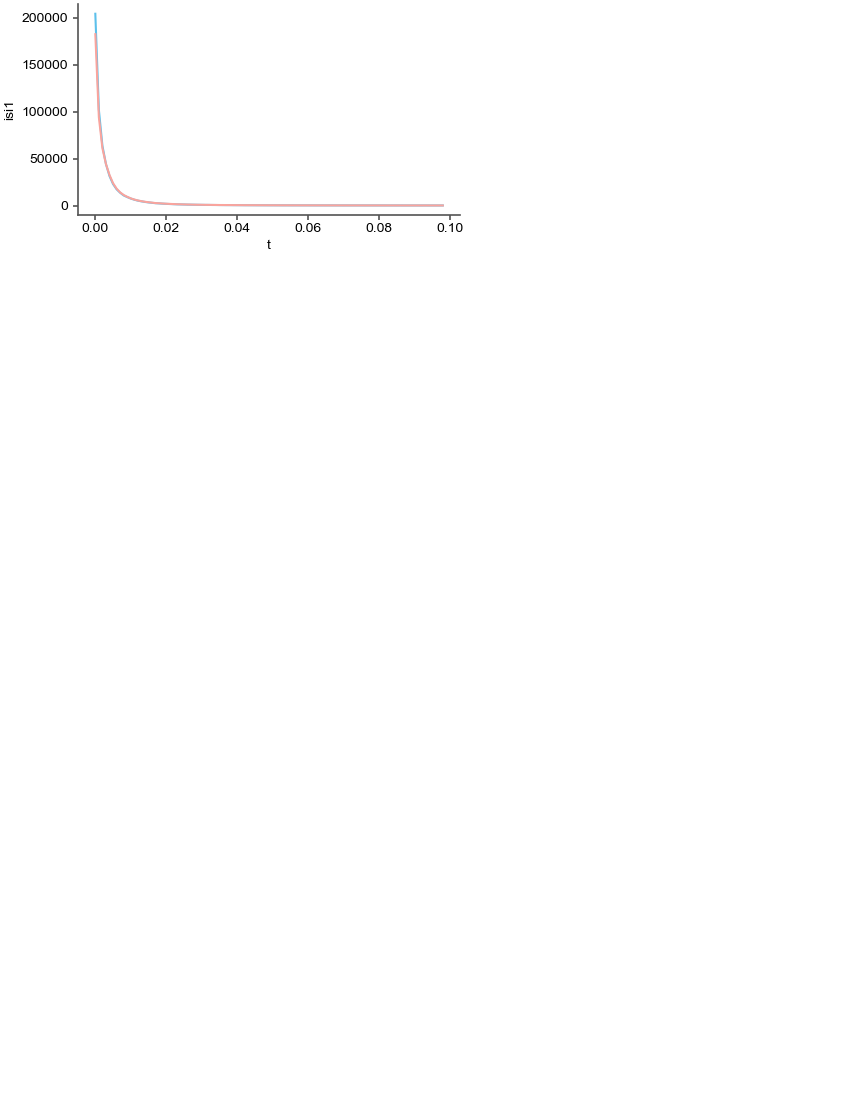

In [70]:
fig = plotting.Fig(grid=(5,2),fontsize=10)

ax = fig.subplot(fig.gs[0])

sns.lineplot(data=isi_df,x='t',y='isi1',ax=ax,ci=None)
sns.lineplot(data=isi_df,x='t',y='isi2',ax=ax,ci=None)

# ax.set_xscale('log')
# ax.set_yscale('log')

# fig.savefig(subjects.figpath_sd/'ripples_around_off')

### Autocorrelation of mua activity from early to late SD

In [ ]:
sessions = subjects.sd.mua_sess

around_peak = lambda x: x[len(x) // 2 - 500 : len(x) // 2 + 501]

acg_df = []
for s, sess in enumerate(sessions):

    post = sess.paradigm["post"].flatten()
    mua1 = sess.mua.time_slice(post[0], post[0] + 2.5 * 3600).spike_counts
    mua2 = sess.mua.time_slice(post[0] + 2.5 * 3600, post[0] + 5 * 3600).spike_counts

    acg_mua1 = around_peak(sg.correlate(mua1, mua1, mode="same"))
    acg_mua2 = around_peak(sg.correlate(mua2, mua2, mode="same"))

    acg_df.append(
        pd.DataFrame(
            {"t": np.linspace(-500, 500, 1001), "acg1": acg_mua1, "acg2": acg_mua2}
        )
    )

acg_df = pd.concat(acg_df,ignore_index=True)

(3884737.725, 5000000.0)

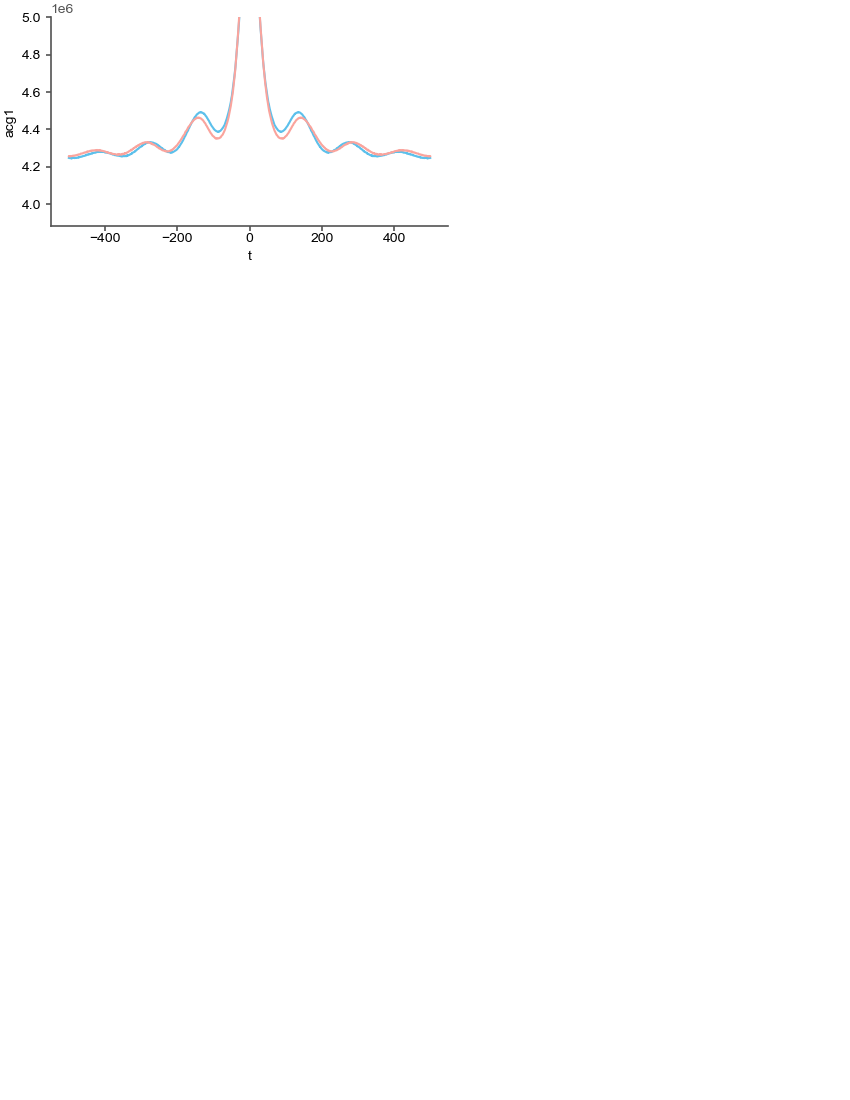

In [37]:
fig = plotting.Fig(grid=(5,2),fontsize=10)

ax = fig.subplot(fig.gs[0])

sns.lineplot(data=acg_df,x='t',y='acg1',ax=ax,ci=None)
sns.lineplot(data=acg_df,x='t',y='acg2',ax=ax,ci=None)

ax.set_ylim(top=5000000)